### Monte Carlo Metropolis Hasting algorithm

Import libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

Density function

In [5]:
def f(x):
    return 0.5* (np.exp(-np.abs(x)))

Function for Random Walk Metropolis algorithm

In [7]:

def rwm_sample(x,s,N):
    '''
    x = initial value for x
    s = standard deviation
    N = number of trials
    '''
    # Our initial value for the algorithm
    previous_number = x
    sample = []
    for i in range(N):    
        # Draw random number in a normal distribution, with the previous number as mean and sd of s
        new_number = np.random.normal(previous_number, s)
        # compute log Ratio
        log_ratio = np.log(f(new_number)) - np.log(f(previous_number))
        # Draw random number in uniform distribution
        u = np.random.uniform(0,1)
        # if log u is lower than log ratio, keep the new number in the sample, else use the previous number
        if (np.log(u) < log_ratio):
            sample.append(new_number)
        else:
            sample.append(previous_number)
        # use the last value of the list as our new previous number
        previous_number = sample[-1]
    return sample

Generate 10,000 samples, with s = 1 and initial value x = 1.

In [13]:
random.seed(1)
sample = rwm_sample(1,1,10000)

### Plotting the sample: <br>
Because I have to plot the density function on top of the sample's histogram, which are both in different units, I have to create a single figure with two y-axis: one for the count/frequency of the histogram, and another one for the probability.

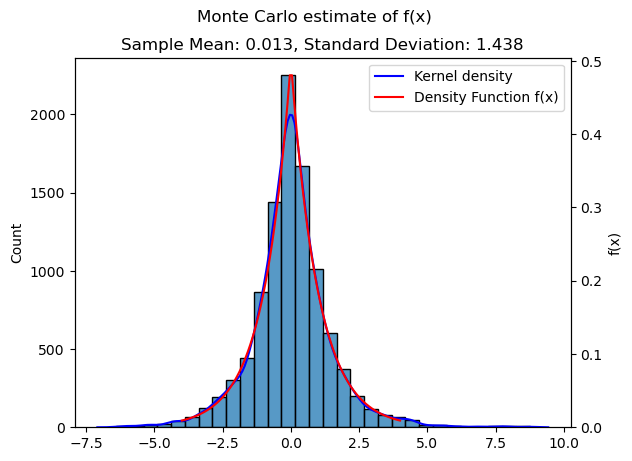

In [16]:
# Sample mean and standard deviation
sample_mean = np.mean(sample)
sample_sd = np.std(sample)

# figure for the plots
fig, ax = plt.subplots()

# histogram of the sample
sns.histplot(sample, 
             bins=30, 
             ax=ax)

# Create a second y-axis for the kernel density and the density function
ax2 = ax.twinx()

# kernel density
sns.kdeplot(x=sample,
            ax=ax2,
            color = 'blue',
            label = 'Kernel density')

# density function
x = np.linspace(-4, 4, 100)
sns.lineplot(x=x,
             y=f(x),
             label='Density Function f(x)',
             color='red',
             ax=ax2)

# labels
plt.ylabel('f(x)')
plt.suptitle('Monte Carlo estimate of f(x)')
plt.title(f'Sample Mean: {sample_mean:.3f}, Standard Deviation: {sample_sd:.3f}')
plt.legend()
plt.show()



### Obtain Convergence Diagnostic.
First I define a function to generate a chain of J samples using Random Walk Metropolis algorithm, with J initial values for the algorithm, and store in a dict.

In [18]:
def chain_samples(x,s,N):
    '''
    Generate a matrix of J amount of chains using Random Walk Metropolis algorithm, 
    with J initial values, and store in a dict.

    x = a list of initial x values for J amount of chains, where the length of the list is J
    s = standard deviation of the samples.
    N = size of each samples.
    '''
    chain = {}
    for i in range(0,len(x)):
        # give a key name for each sample and a list containing its values
        chain[f'chain{i+1}'] = rwm_sample(x[i], s, N)
    return chain
        

Using the function to generate 4 chains with 4 random initial values between 0 and 1 and
- s = 0.001
- N = 2000 

In [20]:
np.random.seed(10)  # Set seed for reproducibility
x1 = np.random.uniform(0, 1)
x2 = np.random.uniform(0, 1)
x3 = np.random.uniform(0, 1)
x4 = np.random.uniform(0, 1)

print(x1, x2, x3, x4)  # Print initial values to check

chains = chain_samples(x = [x1,x2,x3,x4],
                      s = 0.001,
                      N = 2000)

# check first 10 values of first 2 chains
print(chains['chain1'][0:11])
print(chains['chain2'][0:11])

0.771320643266746 0.0207519493594015 0.6336482349262754 0.7488038825386119
[0.7697752429746347, 0.7697668591247062, 0.7700323707103983, 0.7701409192361133, 0.7705739454260668, 0.771776982799879, 0.7720056129300037, 0.7724507505428341, 0.7739352875446707, 0.7728554826588854, 0.773121552822886]
[0.020257485095932053, 0.020232138634731188, 0.020643785247955494, 0.020959419292374045, 0.02006498422673472, 0.020546672641964907, 0.019763905281644793, 0.01956813653006745, 0.01964376662133577, 0.019219954454029145, 0.017348017043388876]


Function to compute the chains' within sample mean and variance and store it in a dict.

In [24]:
def within_sample(chains):
    # dict to store the meean and variance
    within_sample = {}
    # for each sample in the chain, compute its mean and variance and store it into the dict
    for key in chains:
        within_sample[key] = [np.mean(chains[key]),  # mean of the specific sample of the iteration
                              np.var(chains[key])]   # variance
    return within_sample


In [26]:
within_stats = within_sample(chains)
within_stats

{'chain1': [0.7325380400873304, 0.0009433984398858277],
 'chain2': [-0.0188425022670179, 0.0002237803051052983],
 'chain3': [0.7219163711402325, 0.002206240745608872],
 'chain4': [0.759351267364897, 0.00010777810583254441]}

In [27]:
# checking the variance of chain1
mean1 = np.mean(chains['chain1'])

# variance
sumsquared = 0
for i in range(0, len(chains['chain1'])):
    sumsquared += (chains['chain1'][i]-mean1)**2
sumsquared / len(chains['chain1'])

0.0009433984398858288

Function to compute R value (convergence diagnostic)

In [29]:
def R_value(chains):
    # using the function defined earlier to get the within sample stats
    within_stats = within_sample(chains)

    ''' 
    overall within sample variance
    '''
    # compute sum of within sample variance
    sum_variance = 0
    for key in within_stats:
        sum_variance += within_stats[key][1]
    # overall within sample variance = sum of within sample variance / number of chains
    overall_w_var = sum_variance / len(chains)
    # print(f'Overall Within Sample Variance: {overall_w_var}')

    '''
    overall within sample mean
    '''
    # compute sum of within sample mean
    sum_mean = 0
    for key in within_stats:
        sum_mean += within_stats[key][0]

    # overall within sample mean = sum of within sample mean / number of chains
    overall_w_mean = sum_mean / len(chains)
    # print(f'Overall within Sample mean: {overall_w_mean}')

    ''' 
    overall between sample variance
    '''
    # compute sum of (within sample mean - overall within sample mean)^2
    between_sumsquared = 0
    for key in within_stats:
        between_sumsquared += (within_stats[key][0] - overall_w_mean)**2

    # sum of squared variance / number of samples
    between_variance = between_sumsquared / len(chains)
    # print(f'Overall Between Sample Variance: {between_variance}')

    '''
    R Value
    '''
    # R value = sqrt(between var + overall within var/ overall within var)
    R_value = np.sqrt((between_variance + overall_w_var) / overall_w_var)
    return R_value

R value for a chain of 4 chains with random initial values, s = 0.001, N = 2000.

In [33]:
np.random.seed(10)  # Set seed for reproducibility
x1 = np.random.uniform(0, 1)
x2 = np.random.uniform(0, 1)
x3 = np.random.uniform(0, 1)
x4 = np.random.uniform(0, 1)

chains1 = chain_samples(x=[x1,x2,x3,x4],
                       s=0.001,
                       N=2000)
print(R_value(chains1))

11.162472458328498


Keeping N and J fixed, plot values of R with s values in the interval between 0.001 and 1.

In [37]:
# Generate 1000 equally spaced values from 0.001 to 1
s = np.linspace(0.001, 1, num=1000)

# Get R values for each of these values, keeping N and J static
R_values = []
for sd in s:
    chain = chain_samples(x = [x1,x2,x3,x4],  # J = 4
                s = sd,
                N = 2000)
    R_values.append(R_value(chain))

print(R_values[0:11])

[17.689535013025434, 8.494023047134595, 7.338445542629699, 3.325000682433933, 3.555380751810477, 3.766705267044508, 1.837837418839136, 2.7987386647147567, 1.7584234647043555, 2.2468342336484897, 1.7762236401488483]


Plot

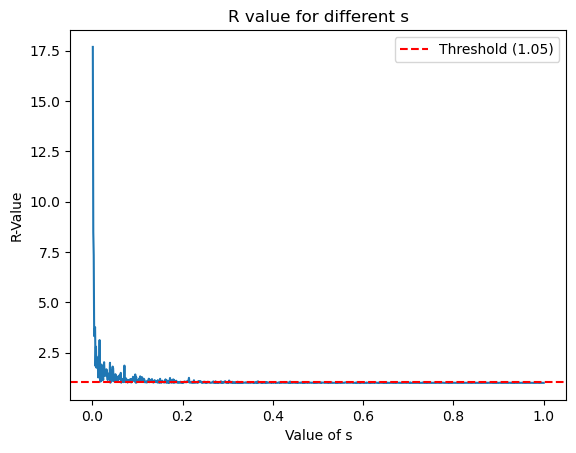

In [39]:
ax = sns.lineplot(x = s,
             y = R_values)
ax.set_title('R value for different s')
ax.set_xlabel('Value of s')
ax.set_ylabel('R-Value')
# Add a horizontal reference line at y = 1.05
ax.axhline(y=1.05, color="red", linestyle="--", label="Threshold (1.05)")
ax.legend()
plt.show()